# Learning Spatial Relationships with MISTy

Here, we show how to use LIANA's implementation of [MISTy](https://github.com/saezlab/mistyR), a framework presented in [Tanevski et al., 2022](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-022-02663-5).

MISTy is a tool that helps us better understand how different features, such as genes or cell types, interact with each other in space. MISTy does so by examining both *intra* and extracellular relationships - i.e. those that occur within and between cells/spots. A major advantage of MISTy is its flexibility. It can model different perspectives, or "views," each describing a different way markers are related to each other. Each of these views can describe a different spatial context, i.e., define a relationship among the observed expressions of the markers, such as intracellular regulation or paracrine regulation. 
These views can also capture specific relationships across different modalities, such as cell type proportions, pathways, or genes.

Each view represents a potential source of variation in the measurements of the (dependent) variables in the intra view. MISTy further analyzes each view to determine how it contributes to the overall expression or abundance of each dependent variable. It explains this contribution by identifying the interactions between measurements that led to the observed results.


<img src="https://uc872487a39c2784cec08c28e197.dl.dropboxusercontent.com/cd/0/inline/B-QLP9EJOda04CFCHWxr28wolLrT841ZzPOcq0HHwKczscxqDk5XcN-y96YWYwbDDobu5mbbaslFpRQ3ja2W_aTRkIliIdfmhz2ExV2qOVFyyJYaDvYjAN39_Vp_Kh4uO7QCGREbUpiy2qSWULNgcY4J7a9IzqkTIHhcXD1U2MkIKg/file#" width=1000 />

To showcase MISTy, we use a single 10x Visium slide from [Kuppe et al. (2022)](https://www.nature.com/articles/s41586-022-05060-x).

## Environment

```
pip install squidpy
pip install decoupler

```

In [1]:
import numpy as np
import scanpy as sc
import squidpy as sq
import decoupler as dc
import plotnine as p9

In [2]:
import liana as li
from liana.method import MistyData, genericMistyData, lrMistyData

Load Data

In [3]:
# TODO: upload this to Zenodo or something?
adata = sc.read_h5ad('/media/dbdimitrov/SSDDimitrov/data/kuppe_visium/Visium_19_CK297.h5ad')

In [4]:
adata.obs.head()

,in_tissue,array_row,array_col,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,mt_frac,celltype_niche,molecular_niche
AAACAAGTATCTCCCA-1,1,50,102,Visium_19_CK297,3125,8.047510,7194.0,8.881142,24.770642,31.387267,39.797053,54.503753,0.085630,ctniche_1,molniche_9
AAACAATCTACTAGCA-1,1,3,43,Visium_19_CK297,3656,8.204398,10674.0,9.275660,35.956530,42.167885,49.456624,61.045531,0.033275,ctniche_5,molniche_3
AAACACCAATAACTGC-1,1,59,19,Visium_19_CK297,3013,8.011023,7339.0,8.901094,33.247036,39.910069,47.227143,59.326884,0.029139,ctniche_5,molniche_3
AAACAGAGCGACTCCT-1,1,14,94,Visium_19_CK297,4774,8.471149,14235.0,9.563529,22.739726,29.884089,37.850369,51.099403,0.149194,ctniche_7,molniche_2
AAACAGCTTTCAGAAG-1,1,43,9,Visium_19_CK297,2734,7.913887,6920.0,8.842316,35.664740,42.268786,50.000000,62.384393,0.025601,ctniche_5,molniche_3


Spot clusters

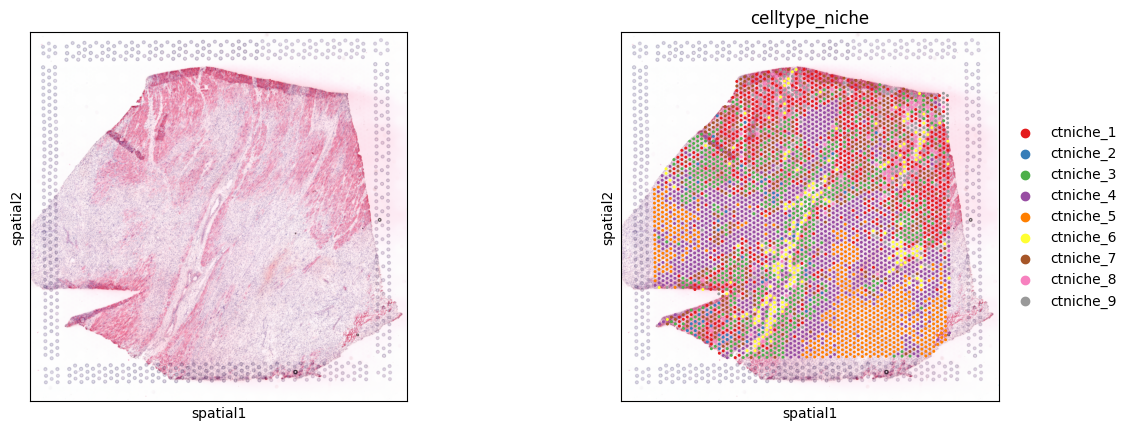

In [5]:
sq.pl.spatial_scatter(adata, color=[None, 'celltype_niche'], size=1, palette='Set1')

Cell type proportions

This slide comes with already processed cell type proportions. Let's extract them to an AnnData object.

In [6]:
comps = li.fun.obsm_to_adata(adata, 'compositions')

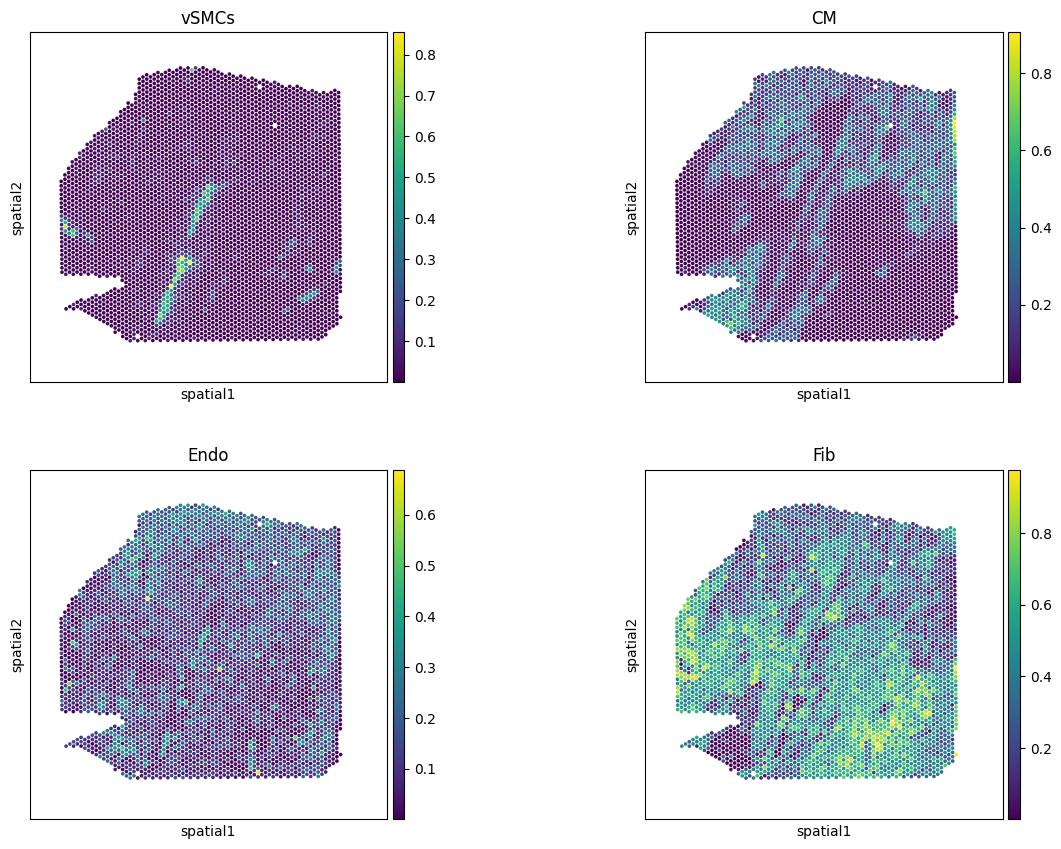

In [7]:
# check key cell types
sq.pl.spatial_scatter(comps, color=['vSMCs','CM', 'Endo', 'Fib'], size=1.3, ncols=2, img_alpha=0)

Normalize data

In [8]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### Funcomics

Before we run MISTy, let's estimate pathway activities as a way to make the data a bit more interpretable.
We will use [decoupler-py](https://academic.oup.com/bioinformaticsadvances/article/2/1/vbac016/6544613) with pathways genesets from [PROGENy](https://www.nature.com/articles/s41467-017-02391-6). See [this tutorial](https://decoupler-py.readthedocs.io/en/latest/notebooks/spatial.html) for details.

In [10]:
# obtain genesets
progeny = dc.get_progeny(organism='human', top=500)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [11]:
# use multivariate linear model to estimate activity
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False,
)

Running mlm on mat with 4113 samples and 17703 targets for 14 sources.


100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


In [12]:
# extract progeny activities as an AnnData object
acts_progeny = li.fun.obsm_to_adata(adata, 'mlm_estimate')

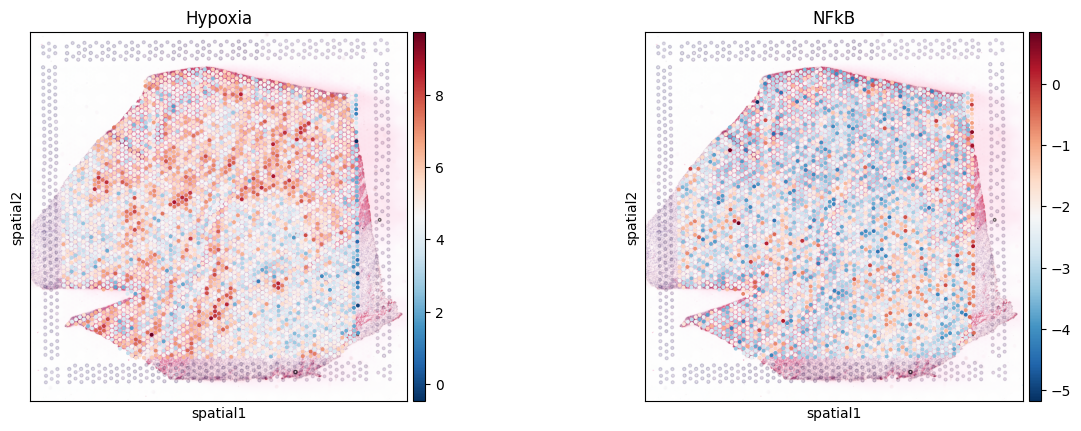

In [13]:
# Check how the pathway activities look like
sq.pl.spatial_scatter(acts_progeny, color=['Hypoxia', 'NFkB'], cmap='RdBu_r', size=1.3)

### Running MISTy

The implementation of MISTy in LIANA makes extends [MuData](https://github.com/scverse/mudata) objects [(Bredikhin et al., 2022)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02577-8), to a very simple child class we call "MistyData". 
To make it easier to use, we provide functions to construct a "MistyData" objects that transform the data into a format that MISTy can use.

Briefly, a "MistyData" object is just a MuData object with **intra** as one of the modalities - this is the view in which the variables explained by all other views are stored. 
MISTy is flexible to any other view that is appended, provided it also contains a spatial neighbors graph.

Let's use `genericMistyData` to construct a MuData object with the intra view and the cell type proportions as the first view.
Then it additionally build a 'juxta' view for the spots that are neighbors of each other, and a 'para' view for all surrounding spots within a certain radius, or bandwidth.

In this case, we will use cell type compositions per spot as the intra view, and we will use the PROGENy pathway activities as the juxta and para views:

In [14]:
misty = genericMistyData(intra=comps, extra=acts_progeny, cutoff=0.05, bandwidth=200, coord_type='generic', n_rings=1)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [15]:
misty

MuData object with n_obs × n_vars = 4113 × 39
  obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
  3 modalities
    intra:	4113 x 11
      obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
      obsm:	'spatial'
    juxta:	4113 x 14
      obsm:	'spatial'
      obsp:	'spatial_connectivities'
    para:	4113 x 14
      obsm:	'spatial'
      obsp:	'spatial_connectivities'

#### Learn Relationships with MISTy

Now that we have constructed the object, we can learn the different views.

In [16]:
misty(verbose = True)

Now learning: vSMCs: 100%|██████████| 11/11 [00:53<00:00,  4.85s/it]  


MISTy will then return two DataFrames:
* `target_metrics` - the metrics that describe the target variables from the intra view, including R-squared across different views as well as the estimated contributions to the predictive performance of each view per target.
* `interactions` - feature importances per view

Let's check the variance explained when predicting the variables in the intra view, with the intra view itself: we see that it explains itself relatively well (as expected).


In [17]:
misty.uns['target_metrics'].head()

,target,intra_R2,multi_R2,gain_R2,intra,juxta,para
0,Adipo,0.215315,0.279058,0.063743,0.502847,0.243877,0.253277
1,CM,0.877470,0.892319,0.014850,0.780453,0.037678,0.181869
2,Endo,0.740765,0.740782,0.000018,0.955763,0.007449,0.036788
3,Fib,0.935028,0.935156,0.000128,0.966020,0.000000,0.033980
4,Lymphoid,0.108310,0.139884,0.031574,0.541284,0.142692,0.316024


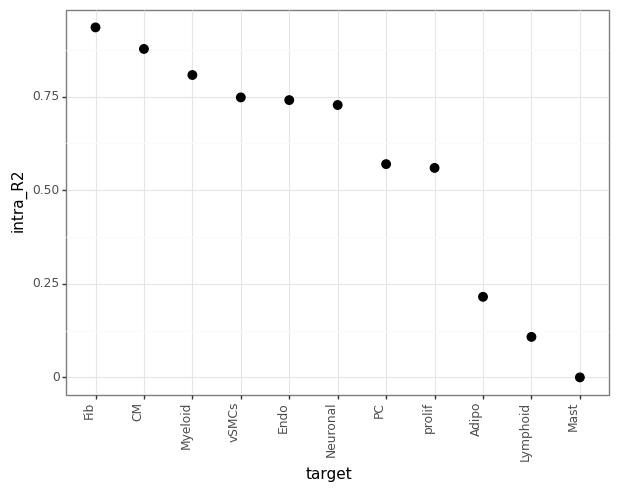

<ggplot: (8726786758431)>

In [18]:
li.pl.target_metrics(misty, stat='intra_R2', return_fig=True)

However, when we look at the variance explained by the other views, we see that they explain a bit less, but still there is some gain of performance, when we include them to the model:

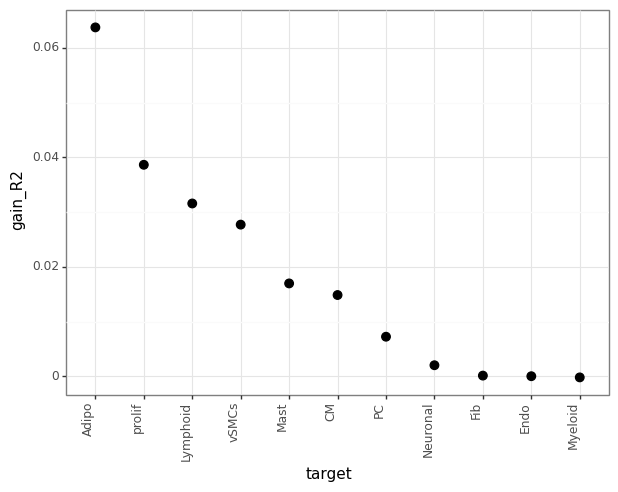

<ggplot: (8726786756789)>

In [19]:
li.pl.target_metrics(misty, stat='gain_R2')

We can also check the contribution to the predictive performance of each view per target:

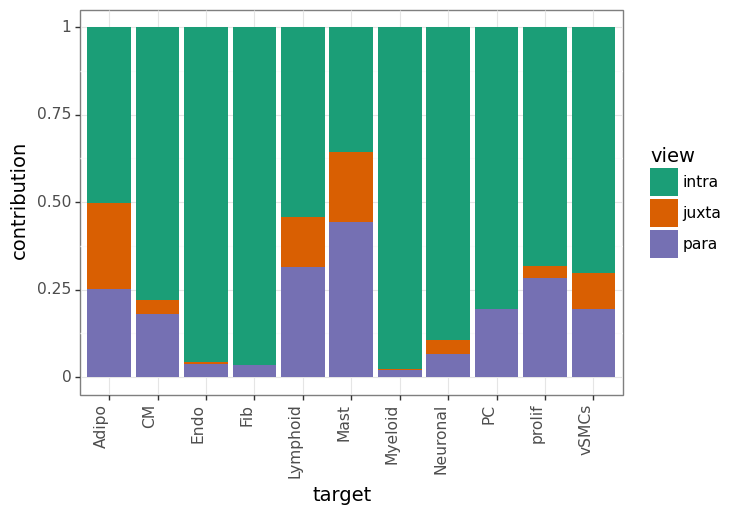

<ggplot: (8726786661334)>

In [20]:
li.pl.contributions(misty, return_fig=True)

Finally, using the information above we know which variables are best explained by our model, and we know which view explains them best. 
So, we can now also see what are the specific variables that explain each target best:

In [21]:
# this information is stored here:
misty.uns['interactions'].head()

,target,predictor,intra_group,extra_group,view,importances
0,Adipo,CM,None,None,intra,0.063997
1,Adipo,Endo,None,None,intra,0.077043
2,Adipo,Fib,None,None,intra,0.054170
3,Adipo,Lymphoid,None,None,intra,0.048505
4,Adipo,Mast,None,None,intra,0.131783


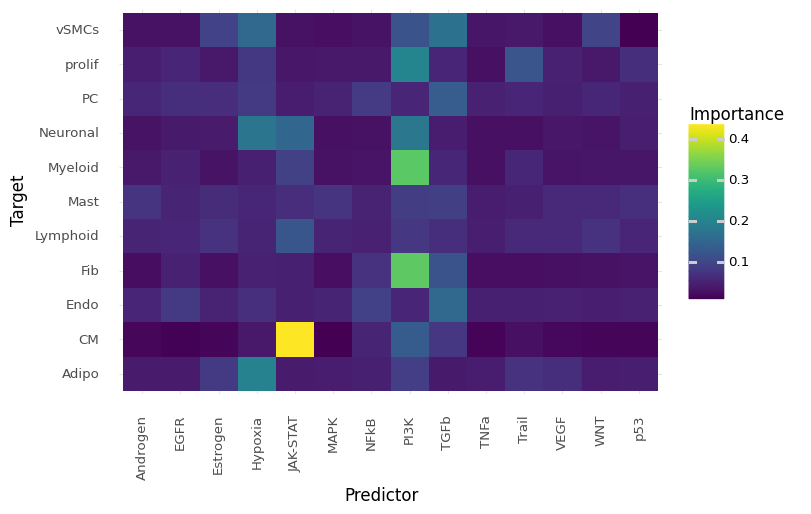

<ggplot: (8726786522581)>

In [22]:
li.pl.interactions(misty, view='juxta', return_fig=True)

#### Linear Misty

By default, MISTy uses a Random Forest to learn the relationships within the views.
However, we can also use a Linear model, which is much faster and more interpretable.

Moreover, will **bypass** predicting the intraview with features within the intraview features (`bypass_intra`).
This will allow us to see how well the other views explain the intraview, excluding the intraview itself.

In [23]:
misty(verbose = True, model='linear', k_cv=10, seed=1337, bypass_intra=True)

Now learning: vSMCs: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]  


Let's check the joined R-squared for views:

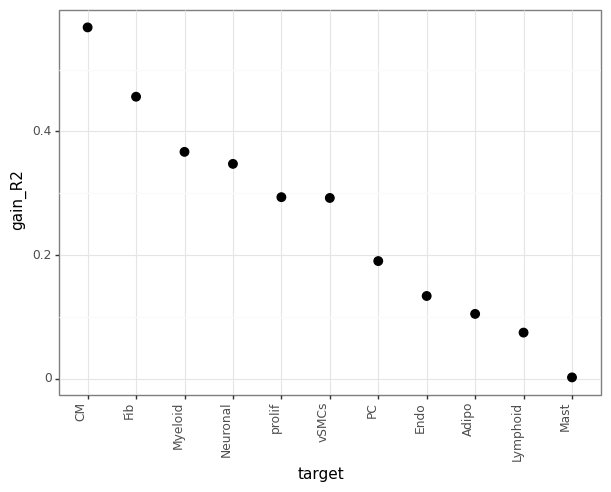

<ggplot: (8726791237741)>

In [24]:
li.pl.target_metrics(misty, stat='gain_R2', return_fig=True)

and their contributions per target:

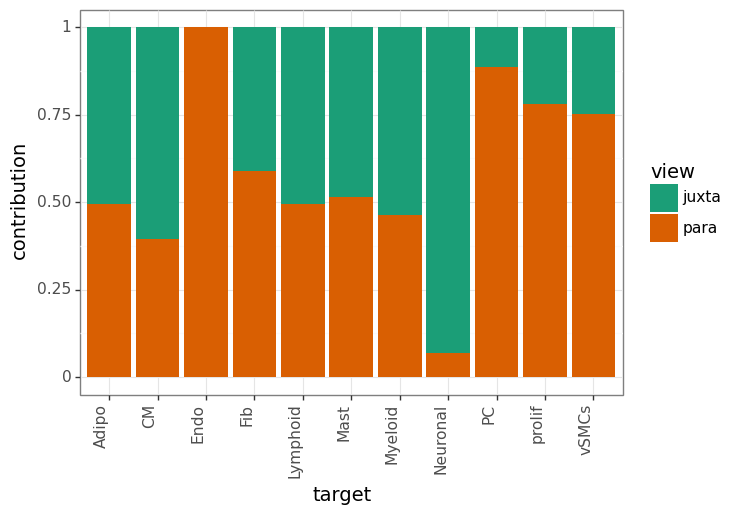

<ggplot: (8726791238098)>

In [25]:
li.pl.contributions(misty, return_fig=True)

Finally, since this is a linear model, we can explore the coefficients for each target-prediction interaction:

<div class="alert alert-info">

**Note**
    
<h4> Feature importances </h4>

Regardless of the model, each target is predicted independently, and the interpretation of feature importances depends on the model used. 
By default, we use a random forest, so the feature importances are the mean decrease in Gini impurity of the features.


</div>  

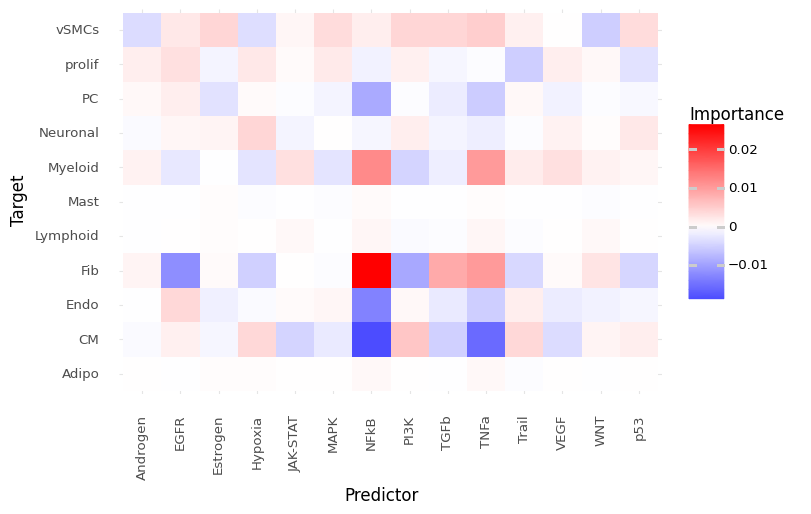

<ggplot: (8726791427301)>

In [26]:
(li.pl.interactions(misty, view='juxta', return_fig=True) + 
 p9.scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0)
)

##### NOTE: the coefficient depend on the scale of the targets!

### Build Custom Misty Views

As we previously mentioned, one can build any view structure that they deem relevant for their data.
So, let's explore how to build custom views.
Here, we will just use two distinct pathway resources to check which one achieves better predictive performance.

So, let's use MSigDB pathways with over-representation analysis (ORA):

In [39]:
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP
...,...,...,...
3838543,PRAMEF22,go_biological_process,GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...
3838544,PRAMEF22,go_biological_process,GOBP_APOPTOTIC_PROCESS
3838545,PRAMEF22,go_biological_process,GOBP_REGULATION_OF_CELL_DEATH
3838546,PRAMEF22,go_biological_process,GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS


In [40]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']
# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]
msigdb

,genesymbol,collection,geneset
233,MAFF,hallmark,IL2_STAT5_SIGNALING
250,MAFF,hallmark,COAGULATION
270,MAFF,hallmark,HYPOXIA
373,MAFF,hallmark,TNFA_SIGNALING_VIA_NFKB
377,MAFF,hallmark,COMPLEMENT
...,...,...,...
1449668,STXBP1,hallmark,PANCREAS_BETA_CELLS
1450315,ELP4,hallmark,PANCREAS_BETA_CELLS
1450526,GCG,hallmark,PANCREAS_BETA_CELLS
1450731,PCSK2,hallmark,PANCREAS_BETA_CELLS


In [41]:
dc.run_ora(
    mat=adata,
    net=msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True,
    use_raw=False,
)


Running ora on mat with 4113 samples and 17703 targets for 50 sources.


100%|██████████| 4113/4113 [00:39<00:00, 104.64it/s]
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10


In [42]:
acts_msigdb = li.fun.obsm_to_adata(adata, 'ora_estimate')

In [43]:
# # NaN and Info to 0
acts_msigdb.X[np.isnan(acts_msigdb.X)] = 0
acts_msigdb.X[np.isinf(acts_msigdb.X)] = 0

In addition to the features, we also need to provide spatial weights for the spots.
Here, we will use LIANA's inbuilt radial kernel function to compute spatial weights based on the spatial coordinates of the spots.
However, this can be replaced by any other spatial weights matrix, such as those calculated via `squidpy.gr.spatial_neighbors`.

In [44]:
# Calculate spatial neighbors
li.mt.spatial_neighbors(acts_msigdb, cutoff=0.1, bandwidth=200, set_diag=False)

Visualize the weights for a specific spot:

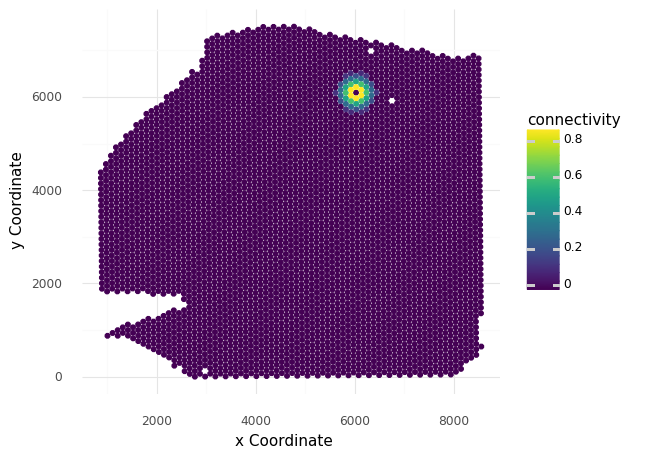

<ggplot: (8726791496221)>

In [33]:
li.pl.connectivity(acts_msigdb, idx=0)

In [34]:
# transfer spatial information to progeny activities
acts_progeny.obsm['spatial'] = acts_msigdb.obsm['spatial']
acts_progeny.obsp['spatial_connectivities'] = acts_msigdb.obsp['spatial_connectivities']

Build an object with custom views:

In [45]:
misty = MistyData(data={"intra": comps, "msigdb": acts_msigdb, "progeny": acts_progeny})

In [46]:
misty

MuData object with n_obs × n_vars = 4113 × 75
  obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
  3 modalities
    intra:	4113 x 11
      obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
      uns:	'spatial', 'celltype_niche_colors'
      obsm:	'compositions', 'mt', 'spatial'
    msigdb:	4113 x 50
      obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
      uns:	'spatial', 'celltype_niche_colors', 'log1p', 'hvg'
      obsm:	'compositions', 'mt', 'spatial', 'mlm_estimate', 'mlm_pvals', 'ora_estimate', 'ora_pvals'
      obsp:	'spatial_connectivities'
    progeny:	4113 x 14
      obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
      uns:	'spatial', 'celltype_niche_colors', 'log1p', 'hvg'
      obsm:	'compositions', 'mt', 'spatial', 'mlm_estimate', 'mlm_pvals'
      obsp:	'spatial_connectivities'

Run Misty as before:

In [47]:
misty(model='linear', verbose=True, bypass_intra=True)

Now learning: vSMCs: 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]  


We see that MSigDB achieves better predictive performance, likely due to it's larger feature size.

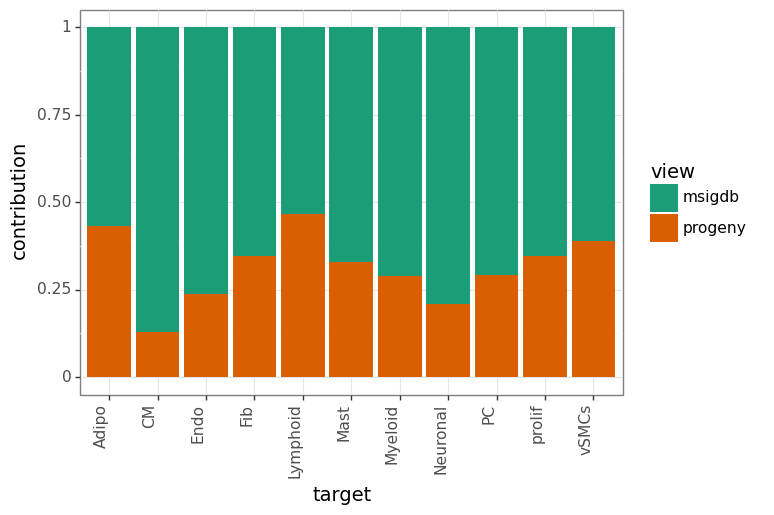

<ggplot: (8726792850763)>

In [48]:
li.pl.contributions(misty, return_fig=True)

### Ligand-Receptor Misty

Finally, we provide a utility function that build an object with receptors in the intra view and ligands in the para view (or in their surrounding).

For the sake of computational speed, let's identify the highly variable genes

In [49]:
sc.pp.highly_variable_genes(adata)
hvg = adata.var[adata.var['highly_variable']].index

Build LR Misty object:

In [50]:
misty = lrMistyData(adata[:, hvg], bandwidth=200, set_diag=False, cutoff=0.01, nz_threshold=0.1)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:458: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [51]:
misty

MuData object with n_obs × n_vars = 4113 × 161
  obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
  2 modalities
    intra:	4113 x 89
      obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
    extra:	4113 x 72
      obsm:	'spatial'
      obsp:	'spatial_connectivities'

In [52]:
misty(bypass_intra=True, model='linear', verbose=True)

Now learning: CSF3R: 100%|██████████| 89/89 [00:24<00:00,  3.68it/s]      


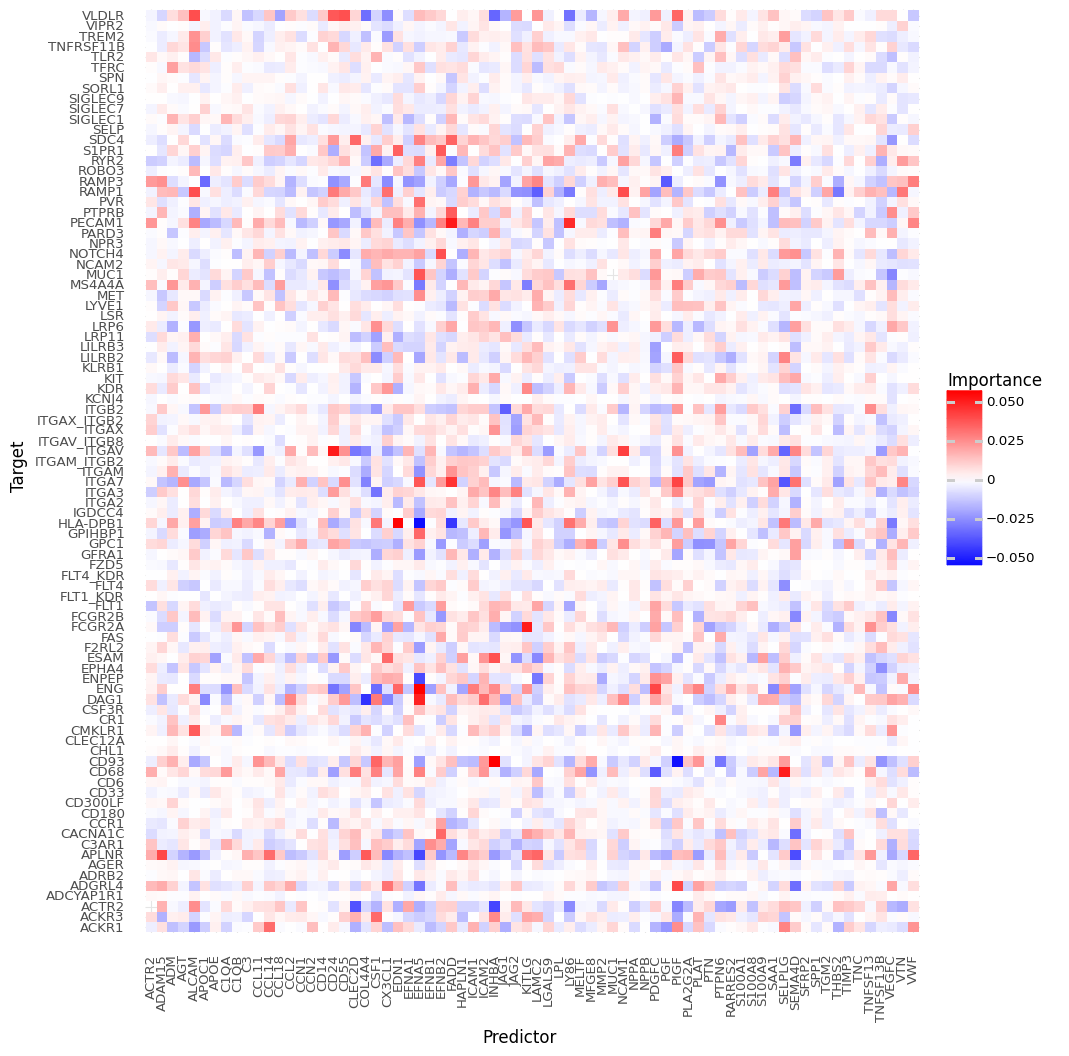

<ggplot: (8726794686897)>

In [53]:
(li.pl.interactions(misty, 'extra', return_fig=True, figure_size=(10, 12)) + 
 p9.scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0)
)

<div class="alert alert-info">

Note that in contrast to any other other functions in LIANA, misty will infer all possible interactions between ligands and receptors, not only those that were annotated specifically as ligand-receptor interactions.

</div>  

### Citing MISTy:

If you use MISTy via LIAAN+, please cite MISTy's original publication ([Tanevski et al., 2022](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-022-02663-5))

Simiarly, consider citing any other database or method that you used in your analysis!